2023/03/16<br>
test

In [498]:
import os
import cv2
import glob
import copy
import numpy as np
from tqdm import tqdm
from skimage.future import graph
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind

In [244]:
current_path=os.getcwd()
npz_path=os.path.join(current_path, "npz_file")
npz_segmentation_files=glob.glob(os.path.join(npz_path, "segmentation", "*.npz"))
npz_MFA_files=glob.glob(os.path.join(npz_path, "pred_im_concatenation", "*.npz"))

Polscope_x40=0.160256 #um/pixel
scaling_list=[Polscope_x40**2, Polscope_x40, 1, 1, 1, Polscope_x40**2, Polscope_x40, 1, 1, 1,  Polscope_x40**2, 1, 1, 1, 1, 1, 1, 1]

In [460]:
npz_segmentation=np.load(npz_segmentation_files[9])
nuclei=npz_segmentation["nuclei"]

npz_MFA=np.load(npz_MFA_files[9])
MFA=npz_MFA["MFA"]
pred_binary=npz_MFA["pred_binary"]

npz_df=np.load(os.path.join(npz_path, "DataFrame_CWT_MFA_anatomy.npz"), allow_pickle=True)
df_list=npz_df["df_list"]
df_target=df_list[9]

RAG drawing

In [74]:
g = graph.rag_mean_color(pred_binary, nuclei)

In [461]:
edge_list=[]
for edge in g.edges.items():
    n1, n2 = edge[0]
    if (n1==0) or (n2==0):
        pass
    else:
        edge_list.append(edge[0])

In [462]:
df_target_scale=df_target*scaling_list
df_target_dropna=df_target_scale.dropna(how="any")
vessel_ind=df_target_dropna[(df_target_dropna["cell_area"]>2000)&(df_target_dropna["cell_eccentricity"]<0.75)].index.values
df_target_area=df_target_dropna[df_target_dropna["cell_area"]>50]

#omit ray
ray_ind=df_target_area[df_target_area["cell_eccentricity"]>0.98].index.values
df_target_area=df_target_area[~df_target_area.index.isin(ray_ind)]

#omit edges of artifacts
cell_ind_list=df_target_area.index.values
cell_ind_list_sub=list(df_target_area.index.values)
edge_list_cell=[edge_list[i] for i in range(len(edge_list)) if edge_list[i][0] in cell_ind_list and edge_list[i][1] in cell_ind_list]
edge_list_cell_copy=copy.deepcopy(edge_list_cell)

adjacent cell extraction

In [463]:
periph_counter=np.zeros((len(cell_ind_list)))
counter=0

vessel_dist_cell_ind_list=[]
while(True):
    if counter==0:
        counter+=1
        
        adj_ind_list=[list(cell_ind_list).index(i) for i in vessel_ind]
        periph_counter[adj_ind_list]=counter
        if len(cell_ind_list_sub)==0:
            break
        
        vessel_dist_cell_ind_list.append(list(vessel_ind))
        
        #get nodes adjacent to vessel
        adj_node_list=[]
        adj_edge_list=[]
        for vessel in vessel_ind:
            adj_1=[edge_list_cell[i][0] for i in range(len(edge_list_cell)) if edge_list_cell[i][1]==vessel]
            adj_2=[edge_list_cell[i][1] for i in range(len(edge_list_cell)) if edge_list_cell[i][0]==vessel]
            adj_edge_1=[edge_list_cell[i] for i in range(len(edge_list_cell)) if edge_list_cell[i][1]==vessel]
            adj_edge_2=[edge_list_cell[i] for i in range(len(edge_list_cell)) if edge_list_cell[i][0]==vessel]
            adj_node_list.extend(adj_1+adj_2)
            adj_edge_list.extend(adj_edge_1+adj_edge_2)
            
        #omit vessel-vessel edge list
        adj_node_list=list(set(adj_node_list)-set(vessel_ind))
        adj_edge_list=[adj_edge_list[i] for i in range(len(adj_edge_list)) if adj_edge_list[i][0] not in vessel_ind or
                                                                               adj_edge_list[i][1] not in vessel_ind]
        
        #subtract nodes from edge list
        cell_ind_list_sub=list(set(cell_ind_list_sub)-set(vessel_ind))
        edge_list_cell_copy=list(set(edge_list_cell_copy)-set(adj_edge_list))
        
        print(counter)
        
    else:
        counter+=1
        #if counter==20:
        #    break
        
        #adj_ind_list=[]
        adj_ind_list=[list(cell_ind_list).index(i) for i in adj_node_list]
        periph_counter[adj_ind_list]=counter
        
        adj_node_list_temp=copy.deepcopy(adj_node_list)
        adj_edge_list_temp=copy.deepcopy(adj_edge_list)
        vessel_dist_cell_ind_list.append(adj_node_list)
        
        adj_node_list=[]
        adj_edge_list=[]
        
        for adj_node in adj_node_list_temp:
            adj_1=[edge_list_cell_copy[i][0] for i in range(len(edge_list_cell_copy)) if edge_list_cell_copy[i][1]==adj_node]
            adj_2=[edge_list_cell_copy[i][1] for i in range(len(edge_list_cell_copy)) if edge_list_cell_copy[i][0]==adj_node]
            adj_edge_1=[edge_list_cell_copy[i] for i in range(len(edge_list_cell_copy)) if edge_list_cell_copy[i][1]==adj_node]
            adj_edge_2=[edge_list_cell_copy[i] for i in range(len(edge_list_cell_copy)) if edge_list_cell_copy[i][0]==adj_node]
            adj_node_list.extend(adj_1+adj_2)
            adj_edge_list.extend(adj_edge_1+adj_edge_2)
        
        #subtract nodes from edge list
        adj_node_list=list(set(adj_node_list)-set(adj_node_list_temp))
        adj_edge_list=list(set(adj_edge_list)-set(adj_edge_list_temp))
        
        cell_ind_list_sub_copy=copy.deepcopy(cell_ind_list_sub)
        cell_ind_list_sub=list(set(cell_ind_list_sub)-set(adj_node_list))
        edge_list_cell_copy=list(set(edge_list_cell_copy)-set(adj_edge_list))
       
        if len(cell_ind_list_sub)==0 or len(edge_list_cell_copy)==0:
            break
        elif counter > len(cell_ind_list):
            break
        elif len(cell_ind_list_sub)==len(cell_ind_list_sub_copy):
            break
        print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [444]:
result_map=np.zeros((nuclei.shape[0], nuclei.shape[1]))
for count in tqdm(np.unique(periph_counter)):
    target_counter_ind=np.where(periph_counter==count)[0]
    target_cell_ind=cell_ind_list[target_counter_ind]
    
    for target_cell in target_cell_ind:
        result_map[np.where(nuclei==target_cell)]=count


100%|██████████| 24/24 [02:34<00:00,  1.17it/s]


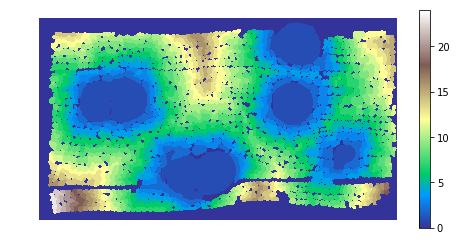

In [445]:
plt.figure(figsize=(8, 4))
plt.imshow(result_map, cmap="terrain", vmin=0, vmax=24)
plt.axis("off")
plt.colorbar()
plt.show()

Extract MFA values depending on ditsances from vessel

In [465]:
vessel_dist_MFA=[]

for vessel_dist_cell_ind in vessel_dist_cell_ind_list:
    df_vessel_dist=df_target_area[df_target_area.index.isin(vessel_dist_cell_ind)]
    vessel_dist_MFA.append(df_vessel_dist["MFA_mode"].values)

visualization and t-test

In [508]:
p_list=[]
stat_sig_list=[]
for i in range(len(vessel_dist_MFA)-1):
    _, p, _ =ttest_ind(vessel_dist_MFA[i], vessel_dist_MFA[i+1], alternative="larger")
    p_list.append(p)
    
    if p<0.01:
        stat_sig_list.append("**")
    elif (p<0.05) and (p>0.01):
        stat_sig_list.append("*")
    else:
        stat_sig_list.append("")

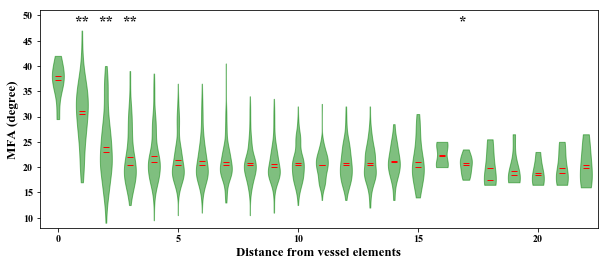

In [519]:
plt.rcParams['font.family']="Times New Roman"
plt.figure(figsize=(10, 4))
violin_parts=plt.violinplot(vessel_dist_MFA, showmeans=True, showmedians=True, positions=np.arange(0, len(vessel_dist_MFA)), 
              showextrema=False)

for partname in ('cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor("red")
    vp.set_linewidth(1)

for vp in violin_parts['bodies']:
    vp.set_facecolor("green")
    vp.set_edgecolor("green")
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
for i, stat_sig in enumerate(stat_sig_list):
    plt.text(i+0.7, 48, stat_sig, size=15)

plt.ylabel("MFA (degree)", size=13)
plt.xlabel("Distance from vessel elements", size=13)
plt.xlim(-0.75, 22.5)
plt.ylim(8, 51)
plt.show()
plt.close()